<a href="https://colab.research.google.com/github/victorwung/twn/blob/master/twn_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
- 第一個欄位SUBSCR_ID的正負號代表兩種不同的用戶(用戶編碼)，其他的欄位你可以望文生義猜測他的意思，或許你可以對這份資料做：
- 1.EDA 看看資料間的關係，找出一些insight
- 2.因為這裡面每筆資料代表的是每一個不同的人，你可以做個cluster 分群，並說明為什麼這樣分群，以及每群以白話文描述其特質嗎？

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
raw_data = pd.read_csv('twm_ds_test.csv')
# raw_data = pd.read_csv('twn/twm_ds_test.csv')

In [3]:
raw_data.shape

(25000, 42)

## Process

In [4]:
# process
raw_data.columns = raw_data.columns.str.lower()
# data = data.fillna(0)

In [5]:
%%time
for col in raw_data.columns[1:]:
    raw_data[col] = raw_data[col].fillna(raw_data[col].median())
#     print('col {} done'.format(col))
print('Fill N/A done.')

Fill N/A done.
CPU times: user 40.3 ms, sys: 956 µs, total: 41.2 ms
Wall time: 53.4 ms


In [6]:
# data.info()

In [7]:
%%time
for col in raw_data.columns[1:]:
    q1_val = np.percentile(raw_data[col], 25)
    q4_val = np.percentile(raw_data[col], 75)
#     print('col:{}, q1:{}, q4:{}'.format(col, q1_val, q4_val))
    col_type = col.replace('_score', '')  
#     col_type = col.replace('score', 'type')
    raw_data[col_type] = raw_data.apply(lambda x: 1 if x[col] <= q1_val else (3 if x[col] >= q4_val else 2), axis=1)
#     print('col {} done'.format(col_type))
print('Assign type done.')

Assign type done.
CPU times: user 21.6 s, sys: 102 ms, total: 21.7 s
Wall time: 30.2 s


In [8]:
raw_data.head()

,subscr_id,taxi_driver_score,buddhism_score,pregnant_score,dating_score,wealth_score,married2020_score,gamble_score,kid_above6_score,high_school2021_score,...,kindness,medicalcare,christian,investor,deliverman,health_life,dpp,sex_demand,camper,married2021
0,6279363,0.113409,0.848155,0.281564,0.257194,0.393156,0.290093,0.468732,0.730413,0.062494,...,1,3,3,1,1,2,3,1,3,3
1,58206281,0.808846,0.029803,0.364543,0.810444,0.118911,0.817450,0.042294,0.152948,0.954729,...,1,1,1,2,3,2,1,1,1,3
2,7046864,0.614134,0.908686,0.869077,0.905806,0.943910,0.712974,0.634033,0.990084,0.192940,...,3,2,3,3,1,3,2,3,3,3
3,11002637,0.564619,0.069156,0.044727,0.108269,0.222076,0.132267,0.696573,0.604216,0.589311,...,3,2,1,1,1,1,3,3,2,2
4,60820330,0.169591,0.431785,0.021300,0.336096,0.223633,0.058069,0.201803,0.625873,0.497099,...,1,3,2,1,1,1,2,3,1,1


## Extract feature types

In [9]:
keep_cols = ['subscr_id'] + raw_data.columns[42:].tolist()

In [10]:
data = raw_data[keep_cols].copy()

In [11]:
data.shape

(25000, 42)

## Clustering

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [13]:
# features
X = data.iloc[:, 1:]

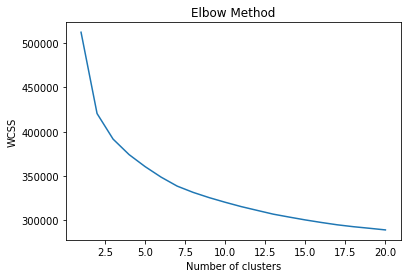

CPU times: user 2min 18s, sys: 15.4 s, total: 2min 33s
Wall time: 1min 39s


In [14]:
%%time
# kmeans
wcss = []
max_num_cluster = 20
for i in range(1, max_num_cluster+1, 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, max_num_cluster+1, 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
%%time
# run kmeans
num_final_cluster = 15
kmeans = KMeans(n_clusters=num_final_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

CPU times: user 7.96 s, sys: 829 ms, total: 8.79 s
Wall time: 4.52 s


In [16]:
data.insert(0, 'cluster_id', '')
data['cluster_id'] = pred_y

In [17]:
data.head()

,cluster_id,subscr_id,taxi_driver,buddhism,pregnant,dating,wealth,married2020,gamble,kid_above6,...,kindness,medicalcare,christian,investor,deliverman,health_life,dpp,sex_demand,camper,married2021
0,9,6279363,1,3,1,1,2,1,2,3,...,1,3,3,1,1,2,3,1,3,3
1,1,58206281,3,1,2,3,1,3,1,1,...,1,1,1,2,3,2,1,1,1,3
2,13,7046864,2,3,3,3,3,3,2,3,...,3,2,3,3,1,3,2,3,3,3
3,3,11002637,2,1,1,1,1,1,2,2,...,3,2,1,1,1,1,3,3,2,2
4,3,60820330,1,2,1,2,1,1,1,2,...,1,3,2,1,1,1,2,3,1,1


In [18]:
data.iloc[:, 2:] = data.iloc[:, 2:].astype(str).apply(lambda x : x.name + '_' + x)

In [19]:
data.head()

,cluster_id,subscr_id,taxi_driver,buddhism,pregnant,dating,wealth,married2020,gamble,kid_above6,...,kindness,medicalcare,christian,investor,deliverman,health_life,dpp,sex_demand,camper,married2021
0,9,6279363,taxi_driver_1,buddhism_3,pregnant_1,dating_1,wealth_2,married2020_1,gamble_2,kid_above6_3,...,kindness_1,medicalcare_3,christian_3,investor_1,deliverman_1,health_life_2,dpp_3,sex_demand_1,camper_3,married2021_3
1,1,58206281,taxi_driver_3,buddhism_1,pregnant_2,dating_3,wealth_1,married2020_3,gamble_1,kid_above6_1,...,kindness_1,medicalcare_1,christian_1,investor_2,deliverman_3,health_life_2,dpp_1,sex_demand_1,camper_1,married2021_3
2,13,7046864,taxi_driver_2,buddhism_3,pregnant_3,dating_3,wealth_3,married2020_3,gamble_2,kid_above6_3,...,kindness_3,medicalcare_2,christian_3,investor_3,deliverman_1,health_life_3,dpp_2,sex_demand_3,camper_3,married2021_3
3,3,11002637,taxi_driver_2,buddhism_1,pregnant_1,dating_1,wealth_1,married2020_1,gamble_2,kid_above6_2,...,kindness_3,medicalcare_2,christian_1,investor_1,deliverman_1,health_life_1,dpp_3,sex_demand_3,camper_2,married2021_2
4,3,60820330,taxi_driver_1,buddhism_2,pregnant_1,dating_2,wealth_1,married2020_1,gamble_1,kid_above6_2,...,kindness_1,medicalcare_3,christian_2,investor_1,deliverman_1,health_life_1,dpp_2,sex_demand_3,camper_1,married2021_1


## Cluster Distribution

In [20]:
cluster_distribution = data[['cluster_id', 'subscr_id']].groupby('cluster_id')['subscr_id'].count().reset_index().rename({'subscr_id': 'cnt'})

In [21]:
cluster_distribution

,cluster_id,subscr_id
0,0,1374
1,1,1438
2,2,3809
3,3,1726
4,4,1610
5,5,985
6,6,876
7,7,1516
8,8,2644
9,9,1633


## Apriori

In [22]:
# apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

### select a clutser

In [23]:
cluster_no = 0
one_clutser_data = data[data['cluster_id']==cluster_no].copy().reset_index(drop=True)

In [24]:
# skip cluster_id, subscr_id
one_clutser_data_features = one_clutser_data.iloc[:, 2:].copy()


In [25]:
one_clutser_data_features.shape

(1374, 41)

In [26]:
# list of list
dataset = one_clutser_data_features.values.tolist() 

### run Apriori

In [27]:
### encode and fit
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df_tx = pd.DataFrame(te_ary, columns=te.columns_)

In [28]:
df_tx.shape

(1374, 123)

In [29]:
### setting threshold
threshold_support = 0.7
threshold_confidence = 0.7 
threshold_lift = 1

In [30]:
### frequent_itemsets
frequent_itemsets = apriori(df_tx, min_support=threshold_support, use_colnames=True)

In [31]:
frequent_itemsets

,support,itemsets
0,0.799854,(age_1)
1,0.844250,(buddhism_1)
2,0.723435,(christian_1)
3,0.818777,(college_student2020_3)
4,0.735808,(dpp_1)
5,0.707424,(hanfan_1)
6,0.762737,(high_school2021_3)
7,0.778020,(kindness_1)
8,0.775109,(wealth_1)
9,0.708151,"(buddhism_1, college_student2020_3)"


In [ ]:
# ### association_rules
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [ ]:
# ### lift>1 的結果
# # target_rules = rules[(rules['lift'] > threshold_lift)].reset_index(drop=True)
# target_rules = rules[(rules['lift'] >= threshold_lift)&(rules['confidence'] >= threshold_confidence)].reset_index(drop=True)


## Function get frequent itemsets

In [32]:
def get_clutser_frequent_itemset(data, cluster_no, threshold_support):
  ### preprocess
  # select one cluster
  one_clutser_data = data[data['cluster_id']==cluster_no].copy().reset_index(drop=True)
  # skip cluster_id, subscr_id
  one_clutser_data_features = one_clutser_data.iloc[:, 2:].copy()
  print('cluster {} shape: {}'.format(cluster_no, one_clutser_data_features.shape))
  # list of list
  dataset = one_clutser_data_features.values.tolist()

  ### encode and fit
  te = TransactionEncoder()
  te_ary = te.fit(dataset).transform(dataset)
  df_tx = pd.DataFrame(te_ary, columns=te.columns_)

  ### frequent_itemsets
  frequent_itemsets = apriori(df_tx, min_support=threshold_support, use_colnames=True)
  print('cluster {} done'.format(cluster_no))

  return frequent_itemsets

In [33]:
### setting threshold
threshold_support = 0.7
# threshold_confidence = 0.7 
# threshold_lift = 1

In [34]:
%%time
# run every cluster
cluster_0_frequent_itemsets = get_clutser_frequent_itemset(data, 0, threshold_support)
cluster_1_frequent_itemsets = get_clutser_frequent_itemset(data, 1, threshold_support)
cluster_2_frequent_itemsets = get_clutser_frequent_itemset(data, 2, threshold_support)
cluster_3_frequent_itemsets = get_clutser_frequent_itemset(data, 3, threshold_support)
cluster_4_frequent_itemsets = get_clutser_frequent_itemset(data, 4, threshold_support)
cluster_5_frequent_itemsets = get_clutser_frequent_itemset(data, 5, threshold_support)
cluster_6_frequent_itemsets = get_clutser_frequent_itemset(data, 6, threshold_support)
cluster_7_frequent_itemsets = get_clutser_frequent_itemset(data, 7, threshold_support)
cluster_8_frequent_itemsets = get_clutser_frequent_itemset(data, 8, threshold_support)
cluster_9_frequent_itemsets = get_clutser_frequent_itemset(data, 9, threshold_support)
cluster_10_frequent_itemsets = get_clutser_frequent_itemset(data, 10, threshold_support)
cluster_11_frequent_itemsets = get_clutser_frequent_itemset(data, 11, threshold_support)
cluster_12_frequent_itemsets = get_clutser_frequent_itemset(data, 12, threshold_support)
cluster_13_frequent_itemsets = get_clutser_frequent_itemset(data, 13, threshold_support)
cluster_14_frequent_itemsets = get_clutser_frequent_itemset(data, 14, threshold_support)

cluster 0 shape: (1374, 41)
cluster 0 done
cluster 1 shape: (1438, 41)
cluster 1 done
cluster 2 shape: (3809, 41)
cluster 2 done
cluster 3 shape: (1726, 41)
cluster 3 done
cluster 4 shape: (1610, 41)
cluster 4 done
cluster 5 shape: (985, 41)
cluster 5 done
cluster 6 shape: (876, 41)
cluster 6 done
cluster 7 shape: (1516, 41)
cluster 7 done
cluster 8 shape: (2644, 41)
cluster 8 done
cluster 9 shape: (1633, 41)
cluster 9 done
cluster 10 shape: (1440, 41)
cluster 10 done
cluster 11 shape: (1285, 41)
cluster 11 done
cluster 12 shape: (1290, 41)
cluster 12 done
cluster 13 shape: (1939, 41)
cluster 13 done
cluster 14 shape: (1435, 41)
cluster 14 done
CPU times: user 2min 14s, sys: 2.13 s, total: 2min 17s
Wall time: 2min 30s


## Observe Results

In [35]:
cluster_0_frequent_itemsets

,support,itemsets
0,0.799854,(age_1)
1,0.844250,(buddhism_1)
2,0.723435,(christian_1)
3,0.818777,(college_student2020_3)
4,0.735808,(dpp_1)
5,0.707424,(hanfan_1)
6,0.762737,(high_school2021_3)
7,0.778020,(kindness_1)
8,0.775109,(wealth_1)
9,0.708151,"(buddhism_1, college_student2020_3)"


In [36]:
cluster_1_frequent_itemsets

,support,itemsets
0,0.887344,(age_1)
1,0.761474,(cat_lover_3)
2,0.805285,(college_student2020_3)
3,0.711405,(dog_lover_3)
4,0.866481,(hanfan_1)
5,0.883866,(jolin_3)
6,0.739917,(ktv_3)
7,0.922809,(lgbt_3)
8,0.776773,(married2020_3)
9,0.808762,(married2021_3)


In [37]:
cluster_2_frequent_itemsets

,support,itemsets
0,0.800210,(baseball_2)
1,0.770543,(beauty_clinic_2)
2,0.885534,(buddhism_2)
3,0.719086,(camper_2)
4,0.788133,(cat_lover_2)
...,...,...
816,0.719611,"(night_club_2, jolin_2, lounge_bar_2, kid_abov..."
817,0.705960,"(kindness_2, jolin_2, lounge_bar_2, night_club_2)"
818,0.710160,"(jolin_2, lounge_bar_2, lgbt_2, night_club_2)"
819,0.707010,"(married2020_2, jolin_2, lounge_bar_2, night_c..."


In [38]:
cluster_3_frequent_itemsets

,support,itemsets
0,0.733488,(age_3)
1,0.824450,(college_student2020_1)
2,0.747972,(deliverman_1)
3,0.814600,(hipster_1)
4,0.911935,(jolin_1)
5,0.701622,(kid_above6_2)
6,0.930475,(ktv_1)
7,0.908459,(lgbt_1)
8,0.715527,(marathon_1)
9,0.880070,(married2020_1)


In [39]:
cluster_4_frequent_itemsets

,support,itemsets
0,0.781988,(buddhism_3)
1,0.819255,(christian_3)
2,0.753416,(dpp_3)
3,0.833540,(estate_mortgage_3)
4,0.731056,(health_life_3)
5,0.764596,(investor_3)
6,0.826087,(kid_above6_3)
7,0.743478,(kindness_3)
8,0.714907,(lounge_bar_3)
9,0.810559,(sex_demand_3)


In [40]:
cluster_5_frequent_itemsets

,support,itemsets
0,0.847716,(gamble_3)
1,0.851777,(sex_demand_3)
2,0.740102,"(sex_demand_3, gamble_3)"


In [41]:
cluster_6_frequent_itemsets

,support,itemsets
0,0.773973,(baseball_3)
1,0.981735,(deliverman_3)
2,0.825342,(hanfan_3)
3,0.981735,(pregnant_3)
4,0.715753,(sex_demand_2)
5,0.765982,"(deliverman_3, baseball_3)"
6,0.763699,"(pregnant_3, baseball_3)"
7,0.817352,"(deliverman_3, hanfan_3)"
8,0.971461,"(pregnant_3, deliverman_3)"
9,0.705479,"(deliverman_3, sex_demand_2)"


In [42]:
cluster_7_frequent_itemsets

,support,itemsets
0,0.754617,(age_3)
1,0.792876,(baseball_1)
2,0.751319,(college_student2020_1)
3,0.762533,(cosmetic_2)
4,0.738127,(deliverman_1)
5,0.757256,(hipster_2)
6,0.710422,(jolin_2)
7,0.736148,(ktv_2)
8,0.738127,(lounge_bar_2)
9,0.710422,(married2020_2)


In [43]:
cluster_8_frequent_itemsets

,support,itemsets
0,0.798033,(age_2)
1,0.930030,(baseball_2)
2,0.986006,(buddhism_2)
3,0.965582,(camper_2)
4,0.985250,(christian_2)
...,...,...
1026834,0.705371,"(hanfan_2, taxi_driver_2, sex_demand_2, pregna..."
1026835,0.701967,"(medicalcare_1, hanfan_2, taxi_driver_2, sex_d..."
1026836,0.705749,"(hanfan_2, taxi_driver_2, sex_demand_2, pregna..."
1026837,0.706884,"(taxi_driver_2, sex_demand_2, pregnant_2, kind..."


In [44]:
cluster_9_frequent_itemsets

,support,itemsets
0,0.875689,(buddhism_3)
1,0.729333,(cat_lover_2)
2,0.769749,(dog_lover_2)
3,0.745254,(estate_mortgage_2)
4,0.701776,(kid_under6_2)
5,0.700551,(wealth_2)


In [45]:
cluster_10_frequent_itemsets

,support,itemsets
0,0.792361,(beauty_clinic_1)
1,0.836806,(buddhism_1)
2,0.705556,(cat_lover_1)
3,0.784028,(christian_1)
4,0.719444,(cosmetic_1)
5,0.777778,(dog_lover_1)
6,0.736806,(estate_mortgage_1)
7,0.886111,(health_life_1)
8,0.800694,(investor_1)
9,0.822222,(jolin_1)


In [46]:
cluster_11_frequent_itemsets

,support,itemsets
0,0.722179,(beauty_clinic_3)
1,0.733074,(cosmetic_3)
2,0.761868,(dog_lover_3)
3,0.782879,(kid_above6_3)
4,0.739300,(kid_under6_3)
5,0.795331,(male_1)


In [47]:
cluster_12_frequent_itemsets

,support,itemsets
0,0.823256,(baseball_1)
1,0.833333,(beauty_clinic_2)
2,0.784496,(cat_lover_2)
3,0.792248,(christian_1)
4,0.846512,(cosmetic_2)
...,...,...
556,0.728682,"(jolin_2, night_club_2, married2020_2, newbaby..."
557,0.729457,"(gamble_2, jolin_2, night_club_2, married2020_..."
558,0.707752,"(gamble_2, jolin_2, beauty_clinic_2, night_clu..."
559,0.719380,"(gamble_2, beauty_clinic_2, night_club_2, marr..."


In [48]:
cluster_13_frequent_itemsets

,support,itemsets
0,0.815369,(beauty_clinic_3)
1,0.750387,(camper_3)
2,0.907169,(cat_lover_3)
3,0.865395,(cosmetic_3)
4,0.875709,(dog_lover_3)
...,...,...
99,0.700361,"(ktv_3, jolin_3, cat_lover_3)"
100,0.719443,"(jolin_3, married2020_3, cat_lover_3)"
101,0.703455,"(cosmetic_3, health_life_3, dog_lover_3)"
102,0.712223,"(cosmetic_3, jolin_3, dog_lover_3)"


In [49]:
cluster_14_frequent_itemsets

,support,itemsets
0,0.859930,(dating_3)
1,0.820906,(deliverman_3)
2,0.765157,(estate_mortgage_3)
3,0.767247,(jolin_3)
4,0.743554,(ktv_3)
5,0.830662,(lender_3)
6,0.734495,(married2020_3)
7,0.735889,(sex_demand_3)
8,0.706620,"(deliverman_3, dating_3)"
9,0.708711,"(dating_3, lender_3)"
